Import modules


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from time import time

import models as m
import utils as u

Loading training and testing data

In [20]:
plt.ion()

X = u.q15_to_lsf(np.load('./data/train/line_spectrum_frequency_low_band_speech.npy'))
y = u.q15_to_lsf(np.load('./data/train/line_spectrum_frequency_high_band_speech.npy'))

X_test = u.q15_to_lsf(np.load('./data/test/line_spectrum_frequency_low_band_speech.npy'))
y_test = u.q15_to_lsf(np.load('./data/test/line_spectrum_frequency_high_band_speech.npy'))

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

num_train_data = X_train.shape[0]
num_valid_data = X_valid.shape[0]
num_test_data = X_test.shape[0]

samples_1 = num_train_data // 100
samples_10 = num_train_data // 10
samples_100 = num_train_data

print("Input Dimension: %d" % (X_train.shape[1]))
print("Output Dimension: %d" % (y_train.shape[1]))

print("Total Training data %d" % (num_train_data))
print("Total Validating data %d" % (num_valid_data))
print("Total Testing data %d" % (num_test_data))

Input Dimension: 10
Output Dimension: 6
Total Training data 400952
Total Validating data 44551
Total Testing data 1386


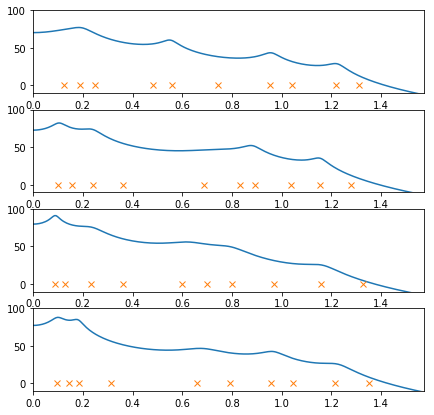

In [21]:
u.plot_lsf(X_train[100:104,:])    

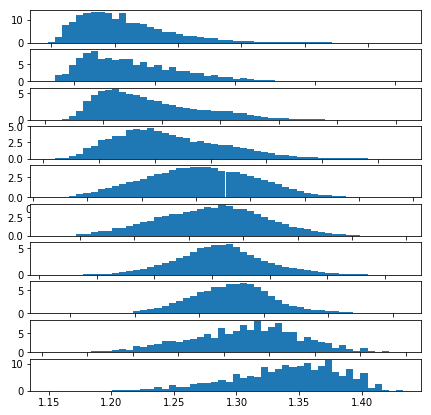

In [22]:
u.plot_lsf_hist(X_train)

In [27]:
results = {}

# build benchmark VQ codebook model
from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import vq

def vq_evaluate(X, y, codebook):
    dim_x = X.shape[1]
    dim_y = y.shape[1]
    
    num_data = X.shape[0]
    c_id, _ = vq(X, codebook[:, :dim_x])
    
    yp = np.zeros_like(y)
    for i in range(num_data):
        yp[i, :] = codebook[c_id[i], -dim_y:]

    return mean_squared_error(y, yp)

results['VQ_Codebook'] = {}
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    
    model_vq = MiniBatchKMeans(n_clusters=64, random_state=0)

    # combine LB and HB LSFs for KMeans clustering
    model_vq.fit(np.hstack((X_train[:samples, :], y_train[:samples, :])))
    codebook = np.array(model_vq.cluster_centers_)

    error_train = vq_evaluate(X_train[:10000, :], y_train[:10000, :], codebook)
    error_valid = vq_evaluate(X_valid, y_valid, codebook)
    error_test = vq_evaluate(X_test, y_test, codebook)

    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("VQ Codebook trained on %d samples." % (samples))

    results['VQ_Codebook'][i] = result
    
print(results['VQ_Codebook'])

VQ Codebook trained on 4009 samples.
VQ Codebook trained on 40095 samples.
VQ Codebook trained on 400952 samples.
{0: {'error_train': 0.009150392381372479, 'error_valid': 0.009270147455576404, 'error_test': 0.010094067829844865}, 1: {'error_train': 0.009143934942253544, 'error_valid': 0.009226647562918387, 'error_test': 0.010270475515010924}, 2: {'error_train': 0.009163599195955123, 'error_valid': 0.009166083015385896, 'error_test': 0.009853918385723704}}


In [32]:
# build benchmark linear regression model
results['Linear_Regression'] = {}
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    
    model_lr = m.linear_regression()
    model_lr.fit(X_train[:samples, :], y_train[:samples, :], epochs=10, batch_size=128, verbose=0)
    
    error_train = model_lr.evaluate(X_train[:10000, :], y_train[:10000, :], batch_size=128, verbose=0)
    error_valid = model_lr.evaluate(X_valid, y_valid, batch_size=128, verbose=0)
    error_test = model_lr.evaluate(X_test, y_test, batch_size=128, verbose=0)
    # print(error_train)
    # print(error_valid)
    # print(error_test)
    
    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("Linear regression model trained on %d samples." % (samples))

    results['Linear_Regression'][i] = result
    
print(results['Linear_Regression'])

Linear regression model trained on 4009 samples.
Linear regression model trained on 40095 samples.
Linear regression model trained on 400952 samples.
{0: {'error_train': 0.026052778685092925, 'error_valid': 0.026075583792259115, 'error_test': 0.027780932660549235}, 1: {'error_train': 0.010989882090687752, 'error_valid': 0.010937128947648771, 'error_test': 0.014591655227615031}, 2: {'error_train': 0.006817592681944371, 'error_valid': 0.0067900556333496676, 'error_test': 0.008237297676267132}}


In [31]:
# build MLP model
results['MLP'] = {}
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    
    model_mlp = m.mlp()
    model_mlp.fit(X_train[:samples, :], y_train[:samples, :], epochs=10, batch_size=128, verbose=0)
    
    error_train = model_mlp.evaluate(X_train[:10000, :], y_train[:10000, :], batch_size=128, verbose=0)
    error_valid = model_mlp.evaluate(X_valid, y_valid, batch_size=128, verbose=0)
    error_test = model_mlp.evaluate(X_test, y_test, batch_size=128, verbose=0)
    # print(error_train)
    # print(error_valid)
    # print(error_test)
    
    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("MLP model trained on %d samples." % (samples))

    results['MLP'][i] = result
    
print(results['MLP'])

MLP model trained on 4009 samples.
MLP model trained on 40095 samples.
MLP model trained on 400952 samples.
{0: {'error_train': 0.009774580064415932, 'error_valid': 0.009749671846334856, 'error_test': 0.014217510728049932}, 1: {'error_train': 0.006994325127452612, 'error_valid': 0.006980294538731032, 'error_test': 0.008356957689658731}, 2: {'error_train': 0.006505632047355175, 'error_valid': 0.006506449433127594, 'error_test': 0.00809871902538821}}
